In [1]:
# Cross-notebook include shim
with open("nbinclude.ipynb") as nbinclude_f: # don't rename nbinclude_f
    import IPython.nbformat.current
    get_ipython().run_cell(IPython.nbformat.current.read(nbinclude_f, 'json').worksheets[0].cells[0].input)

In [2]:
import vrep
import math
import transformations
import numpy as np
import matplotlib.pyplot as plt
import pylab
import numpy as np
import numpy
import scipy
import scipy.stats
import scipy.ndimage
import time
import IPython.display
import sys
import time

Populating the interactive namespace from numpy and matplotlib


In [3]:
class Servo: 
    def __init__(self, cid, base_handle, joint_handle, head_handle):
        self.cid = cid
        self.base_handle = base_handle
        self.joint_handle = joint_handle
        self.head_handle = head_handle
        self.target_position = 0
        self.position_ctrl = False
        
    def get_position(self):
        ec, angle = vrep.simxGetJointPosition(self.cid,
                                              self.joint_handle,
                                              vrep.simx_opmode_streaming)
        return angle
    
    def get_angle(self):
        ec, angles = vrep.simxGetObjectOrientation(self.cid,
                                                   self.head_handle,
                                                   self.base_handle,
                                                   vrep.simx_opmode_streaming)
        return angles
    
    def set_position(self, position):
        self.position_ctrl = True
        self.target_position = position
        return 0
    
    def set_velocity(self, vel):
        return vrep.simxSetJointTargetVelocity(self.cid,
                                                self.joint_handle,
                                                vel,
                                                vrep.simx_opmode_oneshot)
    def _get_rel_angle(self, target_angle):
        # target_angle is on the /base frame.
        # this function returns the angle in the /Neck frame.
        angles = self.get_angle()
        quat=transformations.quaternion_from_euler(angles[0],
                                                   angles[1],
                                                   angles[2],
                                                   'sxyz')
        neck_to_base = transformations.quaternion_matrix(quat)
        base_to_neck = numpy.linalg.inv(neck_to_base)
        
        neck_pt = base_to_neck * np.matrix([[math.cos(target_angle),
                                               math.sin(target_angle),
                                               0,
                                               1]]).T
        return math.atan2(neck_pt[1], neck_pt[0])        
        
    def tick(self):
        if self.position_ctrl:
            error = self._get_rel_angle(self.target_position)
            control_val = 50. * error
            self.set_velocity(control_val)

In [2]:
class Narwhal:
    HANDLES = ['leftMotor',
               'leftMotor0',
               'rightMotor',
               'rightMotor0',
               'Head',
               'Neck',
               'zumo',
               'linescan_camera',
               'Cylinder',
               'Cylinder0',
               'Cylinder1',
               'Cylinder2',
               'Cylinder3',
               'Cylinder4',
               'Cylinder5',
               'Cylinder6'
               ]
    all_narwhals={}
    cid = None
    def __init__(self, cid, nid=0 ):
#         if Narwhal.cid is None:
#             Narwhal.cid = vrep.simxStart('127.0.0.1',port,True,True,5000,5)
        self.cid = cid
        self.nid=nid
        
        self._handles = {}
        for handle in Narwhal.HANDLES:
            self._handles[handle] = self._get_handle(handle)
            
        Narwhal.all_narwhals[nid] = self
        self.neck_servo = Servo(self.cid,
                                self._handles['zumo'],
                                self._handles['Neck'],
                                self._handles['Head'])
        
        
    def _get_handle(self, obj_name):
        if self.nid is 0:
            nid_str = ''
        else:
            nid_str = '#{0}'.format(self.nid - 1)
        ercode, handle = vrep.simxGetObjectHandle(self.cid,
                                                  obj_name + nid_str,
                                                  vrep.simx_opmode_oneshot_wait)
        return handle
    def _get_position(self, handle_name):
        ec, pos = vrep.simxGetObjectPosition(self.cid,
                                             self._handles[handle_name],
                                             -1,
                                             vrep.simx_opmode_streaming)
        return pos
    
    def _get_euler_angles(self, handle_name):
        ec, angles = vrep.simxGetObjectOrientation(self.cid,
                                                   self._handles[handle_name],
                                                   -1,
                                                   vrep.simx_opmode_streaming)
        return angles
    def _set_joint_velocity(self, joint_name, vel):
        return vrep.simxSetJointTargetVelocity(self.cid,
                                            self._handles[joint_name],
                                            vel,
                                            vrep.simx_opmode_oneshot)
    def drive(self, left, right):
        #TODO http://www.coppeliarobotics.com/helpFiles/en/remoteApiModusOperandi.htm
        vrep.simxSetJointTargetVelocity(self.cid,
                                        self._handles['leftMotor'],
                                        -left,
                                        vrep.simx_opmode_oneshot)
        vrep.simxSetJointTargetVelocity(self.cid,
                                        self._handles['leftMotor0'],
                                        -left,
                                        vrep.simx_opmode_oneshot)
        vrep.simxSetJointTargetVelocity(self.cid,
                                        self._handles['rightMotor'],
                                        -right,
                                        vrep.simx_opmode_oneshot)
        vrep.simxSetJointTargetVelocity(self.cid,
                                        self._handles['rightMotor0'],
                                        -right,
                                        vrep.simx_opmode_oneshot)
    def set_neck(self, neck_angle):
        return self.neck_servo.set_position(neck_angle)
#         return vrep.simxSetJointTargetPosition(self.cid,
#                                                 self._handles['Neck'],
#                                                 neck_angle,
#                                                 vrep.simx_opmode_oneshot)
    def set_neck_vel(self, neck_vel):
        return self.neck_servo.set_velocity(neck_vel)
#         return vrep.simxSetJointTargetVelocity(self.cid,
#                                                 self._handles['Neck'],
#                                                 neck_vel,
#                                                 vrep.simx_opmode_oneshot)
    def get_neck_pos(self):
        ec, angle = vrep.simxGetJointPosition(self.cid,
                                              self._handles['Neck'],
                                              vrep.simx_opmode_streaming)
        return angle
    def get_linescan(self):
        ec, res, image = vrep.simxGetVisionSensorImage(self.cid,
                              self._handles['linescan_camera'],
                              0,
                              vrep.simx_opmode_streaming)
        return image

    def _tf_matrix(self, translation, euler_rot):
        quat=transformations.quaternion_from_euler(euler_rot[0],
                                                   euler_rot[1],
                                                   euler_rot[2],
                                                   'sxyz')
        return numpy.dot(transformations.translation_matrix(translation),
                         transformations.quaternion_matrix(quat))
    
    def lightval(self, pt, cone_h, cone_r):
        trans = self._get_position('Head')
        euler_rots = self._get_euler_angles('Head')
        headmat = self._tf_matrix(trans, euler_rots)
        
        point0= headmat * np.matrix([[0, 0, 0, 1]]).T
        direction_vector = headmat * np.matrix([[1, 0, 0, 1]]).T - point0
        
        dummypos_vect = np.matrix([[pt[0], pt[1], pt[2], 1]]).T
       
        dist = np.dot(direction_vector.A1, dummypos_vect.A1)
        dist_vect = dist * direction_vector
        
        radius_at_point = (dist / cone_h) * cone_r
        
        rel_vect = dummypos_vect - point0
        to_get_distance = (rel_vect - dist_vect).A1
        ortho_dist = np.sqrt(np.dot(to_get_distance, to_get_distance))
        light = radius_at_point - ortho_dist
        return 0 if light <=0 else light 

    def get_opponent_score(self, robot_id):
        my_pos = self._get_position('zumo')
        return Narwhal.all_narwhals[robot_id].lightval(my_pos, 10., 10.)

In [5]:
#NBINCLUDE_STOP

In [ ]:
cid = vrep.simxStart('127.0.0.1',19990,True,True,5000,5)

In [5]:
n0 = Narwhal(0,cid)
n1 = Narwhal(1,cid)

In [6]:
Narwhal.all_narwhals

{0: <__main__.Narwhal instance at 0x7f97a57dfdd0>,
 1: <__main__.Narwhal instance at 0x7f97a57dfb00>}

In [7]:
n0.drive(10,0)

In [8]:
n0.drive(0,0)

In [29]:
n0.set_neck(math.pi/3)

0

In [14]:
n0.set_neck(0)

0

In [30]:
while True:
    n0.neck_servo.tick()
    time.sleep(.01)

KeyboardInterrupt: 

In [11]:
targets0 = np.linspace(2*math.pi, 0)
targets1 = np.linspace(0, 2*math.pi)
while True:
    for target in targets0:
        n0.set_neck(target)
        for i in range (10):
            n0.neck_servo.tick()
            time.sleep(.01)
    for target in targets1:
        n0.set_neck(target)
        for i in range (10):
            n0.neck_servo.tick()
            time.sleep(.01)

KeyboardInterrupt: 

In [22]:
n0.set_neck_vel(.1)

0

In [17]:
n0.set_neck_vel(-.1)

0

In [23]:
n0.set_neck_vel(0)

0

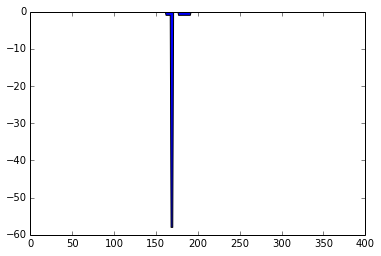

In [25]:
img = np.array(n0.get_linescan())
xs = np.arange(0, img.shape[0])
plt.fill_between(xs, 0, img)

In [26]:
scipy.ndimage.measurements.center_of_mass(img)

(170.01538461538462,)

In [27]:
while True:
    img = np.array(n0.get_linescan())
    IPython.display.clear_output()
    print scipy.ndimage.measurements.center_of_mass(img)
    sys.stdout.flush()
    time.sleep(.05)

(139.07258064516128,)


KeyboardInterrupt: 

In [26]:
angle = math.pi/5.
center = img.shape[0]/2
while True:
    img = np.array(n0.get_linescan())
    com = scipy.ndimage.measurements.center_of_mass(img)[0]
    if com is not np.nan:
        error = center - com
        angle = angle + ( .001 * error)
        n0.set_neck(angle)
        IPython.display.clear_output()
        print com, angle
    sys.stdout.flush()
    time.sleep(.01)

KeyboardInterrupt: 

In [1]:
angle = math.pi/5.
center = img.shape[0]/2
while True:
    img = np.array(n0.get_linescan())
    com = scipy.ndimage.measurements.center_of_mass(img)[0]
    if com is not np.nan:
        error = center - com
        vel = 0.5 * error
        n0.set_neck_vel(vel)
        IPython.display.clear_output()
        print com, angle
    sys.stdout.flush()
    time.sleep(.01)

NameError: name 'math' is not defined

<matplotlib.colorbar.Colorbar instance at 0x7f97a3569680>

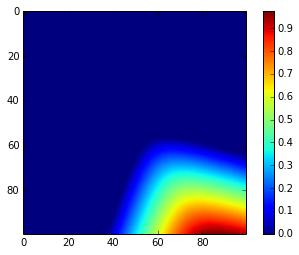

In [31]:
xs = np.linspace(-1.0, 1.0, 100)
ys = np.linspace(-1.0, 1.0, 100)
img=np.ndarray(shape=(len(ys), len(xs)), dtype=float)
for i in xrange(len(xs)):
    for j in xrange(len(ys)):
        x = xs[i]
        y = ys[j]
        img[i][j] = n0.lightval((x,y,0), 10., 10.)
plt.imshow(img)
plt.colorbar()